In [1]:
import os
import pandas as pd
import numpy as np

from src.util import *
from src.arima import ARIMAModel

In [2]:
ROOT = os.getcwd()
MODELS = os.path.join(ROOT, 'models')
METRICS = os.path.join(ROOT, 'metrics')
DATA = os.path.join(ROOT, 'dataset')
FIGURES = os.path.join(ROOT, 'figures')

## Construir Dataset

In [3]:
# Read the CSV file from the dataset folder
file_path = os.path.join(DATA, 'TrafficTwoMonth.csv')
df = pd.read_csv(file_path)

# Create datetime column
df = create_datetime_column(df)
df.drop(['Time', 'Date', 'Day of the week'], axis=1, inplace=True)

## Análisis

Resultados del test de estacionariedad:
Estadístico ADF: -14.4406
Valor p: 0.0000
Valores críticos:
  1%: -3.4315
  5%: -2.8620
  10%: -2.5670
La serie es estacionaria


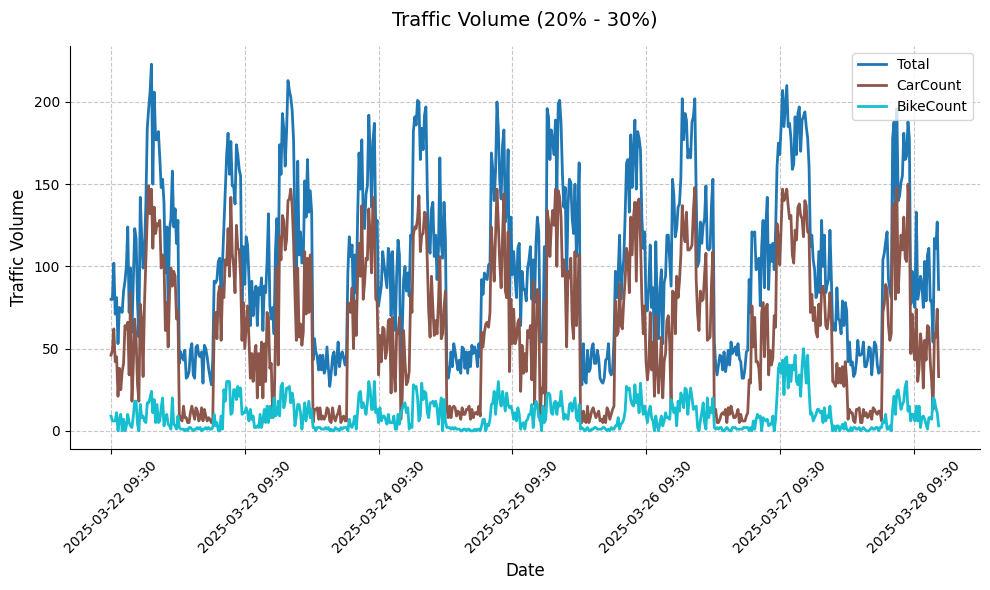

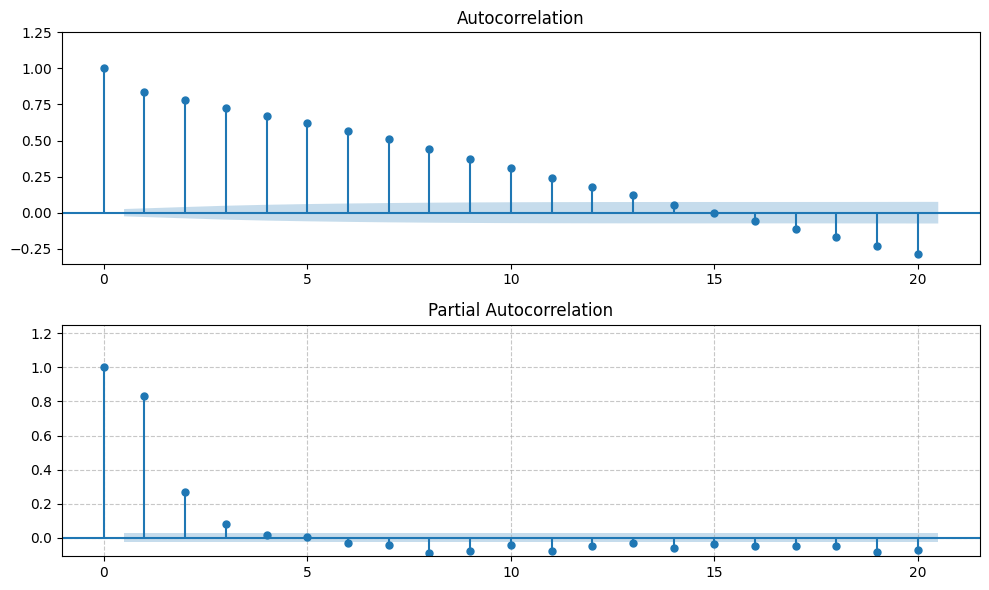

In [4]:
analyser = TrafficAnalyzer(df)

message = analyser.check_stationarity(df['Total'])
print(message)

analyser.plot_time_series(
    figsize=(10, 6), 
    columns=['Total', 'CarCount', 'BikeCount'], 
    xticks_step=96, 
    start_pct=20, 
    end_pct=30,
    save_path=os.path.join(FIGURES, 'time_series_traffic.png'))

analyser.plot_autocorrelation(series=df['Total'], 
                              lags=20, 
                              save_path=os.path.join(FIGURES, 'autocorrelation_traffic.png'))

## ARIMA

### Introducción teórica

El modelo ARIMA (AutoRegressive Integrated Moving Average) es un modelo estadístico que utiliza variaciones y regresiones de datos estadísticos con el fin de encontrar patrones para una predicción hacia el futuro. Se expresa matemáticamente como ARIMA(p,d,q) donde:

- p: orden de la parte autorregresiva (AR)
- d: grado de diferenciación necesario para alcanzar la estacionariedad
- q: orden de la parte de media móvil (MA)

La ecuación general del modelo ARIMA es:

$$(1-\sum_{i=1}^p \phi_i L^i)(1-L)^d y_t = (1+\sum_{i=1}^q \theta_i L^i)\epsilon_t$$

Donde:
- $L$ es el operador de retardo
- $\phi_i$ son los parámetros del modelo AR
- $\theta_i$ son los parámetros del modelo MA
- $\epsilon_t$ es el término de error

### Secuencia de Modelado

1. Primero creamos un modelo ARIMA usando los datos de tráfico total
2. Optimizamos los parámetros del modelo probando diferentes combinaciones de p y q (manteniendo d=0)
3. Ajustamos el modelo con los mejores parámetros encontrados
4. Realizamos predicciones usando rolling forecast con una ventana de entrenamiento del 98% de los datos
5. Visualizamos los resultados comparando las predicciones con los datos reales

In [5]:
p_range = range(0, 6)
q_range = range(0, 6)
d = 0

In [6]:
# Optimización
arima_model = ARIMAModel(df['Total'])
results = arima_model.optimize(p_range, d, q_range)
arima_model.fit()
print("-"*70)
print(results)
print("-"*70)

Optimizando ARIMA:   0%|          | 0/36 [00:00<?, ?it/s]


Resumen de optimización:
Ajustes exitosos: 36/36 (100.0%)

Mejor modelo: ARIMA(3,0,5)
AIC: 56920.04
BIC: 56986.95
----------------------------------------------------------------------
      order           aic           bic  converged error
23  (3,0,5)  56920.042650  56986.947390       True      
35  (5,0,5)  56921.060547  57001.346235       True      
29  (4,0,5)  56923.158361  56996.753576       True      
16  (2,0,4)  56931.071964  56984.597102       True      
17  (2,0,5)  56931.629570  56991.843836       True      
34  (5,0,4)  56934.350225  57007.947289       True      
22  (3,0,4)  56935.445589  56995.661368       True      
28  (4,0,4)  56940.059137  57006.965559       True      
33  (5,0,3)  56941.375336  57008.281758       True      
27  (4,0,3)  56941.930111  57002.147404       True      
15  (2,0,3)  56942.561442  56989.397114       True      
26  (4,0,2)  56948.503786  57002.030268       True      
20  (3,0,2)  56951.343544  56998.180393       True      
21  (3,0,3)  569

In [7]:
# Predicción
window = 1
train_size = int(len(df) * 0.98)
predictions_arima = arima_model.rolling_forecast(train_size, window)

Rolling forecast ARIMA:   0%|          | 0/120 [00:00<?, ?it/s]

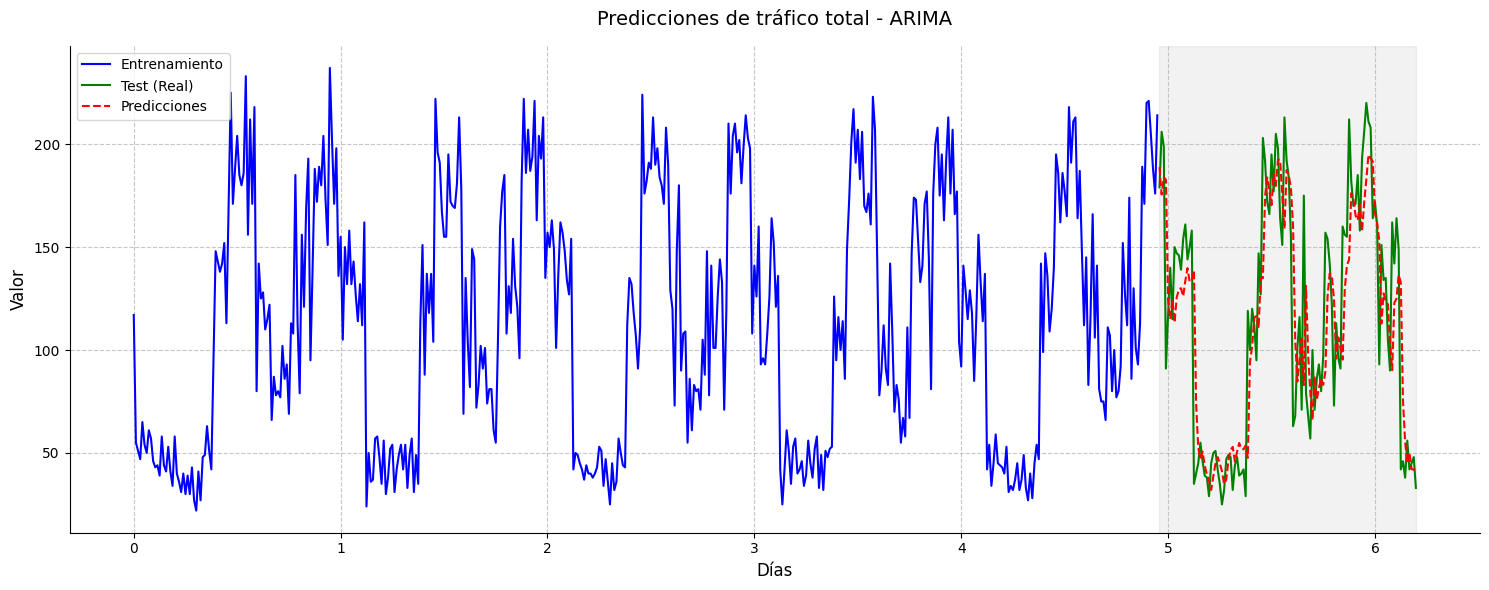

<Figure size 640x480 with 0 Axes>

In [11]:
# Visualización
start_i = int(len(df) * 0.90)
end_i = int(len(df) * 0.98)
arima_model.plot_predictions(
    train_data=df['Total'].values[start_i:end_i],
    test_data=df['Total'].values[end_i:],
    predictions=predictions_arima,
    title='Predicciones de tráfico total - ARIMA',
    save_path=os.path.join(FIGURES, 'arima_predictions.png')
)

In [10]:
# Métricas
test_data = np.array(df['Total'].iloc[int(len(df) * 0.98):])
predictions_arima = np.array(predictions_arima)
arima_metrics = arima_model.calculate_metrics(test_data, predictions_arima)

for key, value in arima_metrics.items():
    print(f"{key}: {value:.4f}")

RMSE: 31.9224
MAE: 22.8470
MAPE: 26.2348
